<a href="https://colab.research.google.com/github/Sirfowahid/Generative_Aspect_Based_Sentiment_Analysis_With_Seq2SeqLM/blob/main/Transformers_Seq2SeqLM_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
checkpoint = "google/mt5-base"
batch_size = 16
lr = 2e-5
epochs = 20
weight_decay = 0.01
path='/content/restaurent rahman et al.xlsx'


In [ ]:
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM,DataCollatorForSeq2Seq,Seq2SeqTrainingArguments,Seq2SeqTrainer

In [ ]:
dataset = pd.read_excel(path)
dataset.head()

,Serial No,Comment,Aspect,Sentiment polarity
0,1,- ইট ক্লাব এনওয়াইসি গ্লুটোনস এর একটি রওয়ের গ...,other,neutral
1,2,", আমাদের পাশের টেবিল থেকে এখনও দূরে ,আমার টেবি...",service,negative
2,3,",সেবাটি একটু ধীর,যেখানে জিনিষ ছুটে যায় না,আপন...",service,conflict
3,4,"($ 200 শ্যাম্পেন 2 গ্লাস জন্য, ওয়াইন খুব ব্যয...",price,negative
4,5,"(আমার ক্ষেত্রে,বা বোন, !)।",other,neutral


In [ ]:
dataset = dataset.drop(['Serial No'],axis=1)
dataset.head()

,Comment,Aspect,Sentiment polarity
0,- ইট ক্লাব এনওয়াইসি গ্লুটোনস এর একটি রওয়ের গ...,other,neutral
1,", আমাদের পাশের টেবিল থেকে এখনও দূরে ,আমার টেবি...",service,negative
2,",সেবাটি একটু ধীর,যেখানে জিনিষ ছুটে যায় না,আপন...",service,conflict
3,"($ 200 শ্যাম্পেন 2 গ্লাস জন্য, ওয়াইন খুব ব্যয...",price,negative
4,"(আমার ক্ষেত্রে,বা বোন, !)।",other,neutral


In [ ]:
dataset['Label'] = dataset['Aspect'] + ' : ' + dataset['Sentiment polarity']
dataset.head()

,Comment,Aspect,Sentiment polarity,Label
0,- ইট ক্লাব এনওয়াইসি গ্লুটোনস এর একটি রওয়ের গ...,other,neutral,other : neutral
1,", আমাদের পাশের টেবিল থেকে এখনও দূরে ,আমার টেবি...",service,negative,service : negative
2,",সেবাটি একটু ধীর,যেখানে জিনিষ ছুটে যায় না,আপন...",service,conflict,service : conflict
3,"($ 200 শ্যাম্পেন 2 গ্লাস জন্য, ওয়াইন খুব ব্যয...",price,negative,price : negative
4,"(আমার ক্ষেত্রে,বা বোন, !)।",other,neutral,other : neutral


In [ ]:
dataset.Label[:5]

0       other : neutral
1    service : negative
2    service : conflict
3      price : negative
4       other : neutral
Name: Label, dtype: object

In [ ]:
len(dataset.Label.unique())

129

In [ ]:
modified_dataset = dataset[['Comment','Label']]
modified_dataset.head()

,Comment,Label
0,- ইট ক্লাব এনওয়াইসি গ্লুটোনস এর একটি রওয়ের গ...,other : neutral
1,", আমাদের পাশের টেবিল থেকে এখনও দূরে ,আমার টেবি...",service : negative
2,",সেবাটি একটু ধীর,যেখানে জিনিষ ছুটে যায় না,আপন...",service : conflict
3,"($ 200 শ্যাম্পেন 2 গ্লাস জন্য, ওয়াইন খুব ব্যয...",price : negative
4,"(আমার ক্ষেত্রে,বা বোন, !)।",other : neutral


In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,dataframe,tokenizer,source_max_len,target_max_len):
    self.tokenizer = tokenizer
    self.dataframe = dataframe
    self.source_max_len = source_max_len
    self.target_max_len = target_max_len
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self,idx):
    row = self.dataframe.iloc[idx]
    source = row['Comment']
    target = row['Label']

    source_encoding = self.tokenizer.encode_plus(
        source,
        max_length=self.source_max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    target_encoding = self.tokenizer.encode_plus(
        target,
        max_length=self.target_max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    input_ids = source_encoding['input_ids'].squeeze()
    attention_mask = source_encoding['attention_mask'].squeeze()
    labels = target_encoding['input_ids'].squeeze()

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

In [ ]:

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
from datasets import load_metric

bleu = load_metric("sacrebleu")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    bleu_score = bleu.compute(predictions=pred_str, references=[[label] for label in label_str])

    return {
        'bleu': bleu_score['score'],
    }


The repository for sacrebleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sacrebleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
training_stats = []
import transformers
class LoggingCallback(transformers.TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        if state.log_history:
            training_stats.append(state.log_history[-1])


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model_name = "Gen_ABSA"
args = Seq2SeqTrainingArguments(
    output_dir=model_name,
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,                # Reduced batch size
    per_device_eval_batch_size=8,                 # Reduced batch size
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    warmup_steps=500,
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=4,                # Accumulate gradients to simulate larger batch size
    eval_accumulation_steps=10,
    report_to="tensorboard",
    dataloader_num_workers=2                      # Reduced number of workers
)

# Additional fine-tuning options
lr = 3e-5
batch_size = 8
weight_decay = 0.01
epochs = 5

args.learning_rate = lr
args.per_device_train_batch_size = batch_size
args.per_device_eval_batch_size = batch_size
args.weight_decay = weight_decay
args.num_train_epochs = epochs

# Clear cache before starting training
import torch
torch.cuda.empty_cache()

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=CustomDataset(modified_dataset.head(1500),tokenizer,128,128),
    eval_dataset=CustomDataset(modified_dataset.tail(300),tokenizer,128,128),
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[LoggingCallback()]
)
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu
1,0.000000,nan,0.030829
2,0.000000,nan,0.030829
3,0.000000,nan,0.030829
4,0.000000,nan,0.030829
5,0.000000,nan,0.030829


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=235, training_loss=0.0, metrics={'train_runtime': 578.9782, 'train_samples_per_second': 12.954, 'train_steps_per_second': 0.406, 'total_flos': 2248211496960000.0, 'train_loss': 0.0, 'epoch': 5.0})

In [ ]:
def generate_output(model, tokenizer, sentence, max_length=128, device='cuda'):
    model.to(device)
    inputs = tokenizer.encode(sentence, return_tensors="pt", max_length=max_length, truncation=True).to(device)
    outputs = model.generate(inputs, max_length=max_length, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
n = 1509
sentence = modified_dataset.Comment.iloc[n]
output = generate_output(model, tokenizer, sentence)
print(f"Inputs:  {sentence}")
print(f"Actual:  {modified_dataset.Label.iloc[n]}")
print(f"Predts:  {output}")

Inputs:  রাকস ডিনারের স্থান যা এটি পুরানো বন্ধুদের মধ্যে চালানোর জায়গা ।
Actual:  other : positive
Predts:  <extra_id_0> এটি পুরানো


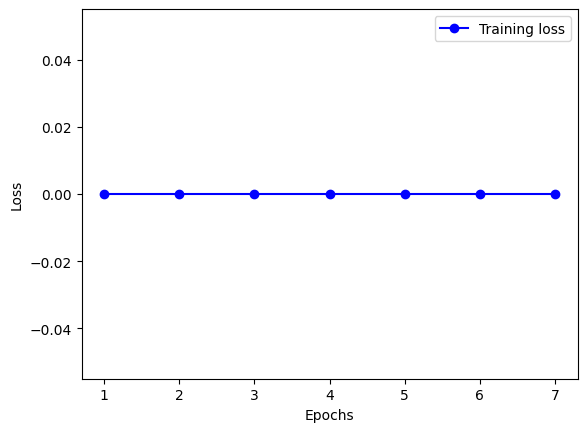

In [ ]:
loss = []
for x in training_stats:
  if 'loss' in x:
    loss.append(x['loss'])
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
eval_loss = []
for x in training_stats:
  if 'eval_loss' in x:
    eval_loss.append(x['eval_loss'])
epochs = range(1, len(eval_loss) + 1)

plt.plot(epochs, eval_loss, 'bo-', label='Evaluation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
eval_bleu = []
for x in training_stats:
  if 'eval_bleu' in x:
    eval_bleu.append(x['eval_bleu'])
epochs = range(1, len(eval_bleu) + 1)

plt.plot(epochs, eval_bleu, 'bo-', label='Evaluation Bleu')
plt.xlabel('Epochs')
plt.ylabel('Bleu')
plt.legend()
plt.show()

In [ ]:
def generate_predictions(model, tokenizer, dataset, device='cuda', max_length=128):
    model.to(device)
    predictions = []

    for sentence in dataset['Comment']:
        inputs = tokenizer.encode(sentence, return_tensors="pt", max_length=max_length, truncation=True).to(device)
        outputs = model.generate(inputs, max_length=max_length, num_beams=4, early_stopping=True)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)

    return predictions

In [ ]:
bleu_metric = load_metric("sacrebleu")
def compute_bleu_scores(predictions, references):

    references = [[ref] for ref in references]

    bleu_score = bleu_metric.compute(predictions=predictions, references=references)

    return bleu_score['score']

In [ ]:

predictions = generate_predictions(model, tokenizer, modified_dataset.head(100), device='cuda')

references = modified_dataset['Label'].tolist()[:100]
bleu_score = compute_bleu_scores(predictions, references)

print(f"BLEU score: {bleu_score}")

BLEU score: 0.05454893347539909
